In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim

In [2]:
REAL_LABEL = 1
FAKE_LABEL = 0
OUT_DIM = 4
n_epoch = 12
lr = 2e-4
batch_size = 32

name = "classical-gan-1.5.2"

path = f"saved/{name}"
datapath = path + "/samples.npz"

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
with np.load(datapath) as data:
    real_samples = data["real_samples"]
    fake_samples_raw = data["fake_samples_raw"]

samples = np.concatenate((real_samples, fake_samples_raw))


real_labels = np.repeat(REAL_LABEL, real_samples.shape[0])
fake_labels = np.repeat(FAKE_LABEL, fake_samples_raw.shape[0])
labels = np.concatenate((real_labels, fake_labels))

X_train, X_rest, y_train, y_rest = train_test_split(
    samples, labels, train_size = 0.6, shuffle = True, stratify = labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rest, y_rest, test_size = 0.5, shuffle = True, stratify = y_rest
)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
y_valid = torch.tensor(y_valid, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)


data_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size = batch_size, shuffle = True)



In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1.0)
        m.bias.data.fill_(0.0)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
class Evaluator(nn.Module):
    def __init__(self):
        super(Evaluator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 16),
            # nn.LeakyReLU(0.2),
            # nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [7]:
netEv = Evaluator().to(device)
netEv.apply(weights_init)

optimizerEv = optim.Adam(netEv.parameters(), lr=lr, betas=(0.5, 0.999))
print(netEv)

Evaluator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [8]:
loss = nn.BCELoss()

optimizer = optim.Adam(netEv.parameters(), lr=lr, betas=(0.5, 0.999))

In [9]:
valid_losses = []
train_losses = []
iters = 0

netEv.train()

print("Starting the training loop")
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):
        netEv.zero_grad()
        X_batch = data[0].to(device)
        y_batch = data[1].to(device)
        prediction_batch = netEv(X_batch).view(-1)
        err = loss(prediction_batch, y_batch)
        err.backward()
        optimizer.step()

        if i%50 == 0:
            netEv.eval()
            with torch.no_grad():
                prediction_valid = netEv(X_valid).view(-1)
                prediction_train = netEv(X_train).view(-1)
            train_loss = loss(prediction_train, y_train).item()
            valid_loss = loss(prediction_valid, y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_acc  = torch.isclose(torch.round(prediction_valid), y_valid).sum().item()/len(y_valid)
            netEv.train()

            print(
                f"[{epoch}/{n_epoch}][{i}/{len(data_loader)}]\tLoss train: {train_loss:.3f}\tLoss valid: {valid_loss:.3f}\tLoss acc: {valid_acc:.3f}"
            )

Starting the training loop
[0/12][0/375]	Loss train: 0.807	Loss valid: 0.814	Loss acc: 0.496
[0/12][50/375]	Loss train: 0.761	Loss valid: 0.766	Loss acc: 0.501
[0/12][100/375]	Loss train: 0.739	Loss valid: 0.743	Loss acc: 0.504
[0/12][150/375]	Loss train: 0.724	Loss valid: 0.727	Loss acc: 0.530
[0/12][200/375]	Loss train: 0.713	Loss valid: 0.716	Loss acc: 0.528
[0/12][250/375]	Loss train: 0.705	Loss valid: 0.708	Loss acc: 0.524
[0/12][300/375]	Loss train: 0.702	Loss valid: 0.704	Loss acc: 0.521
[0/12][350/375]	Loss train: 0.698	Loss valid: 0.700	Loss acc: 0.523
[1/12][0/375]	Loss train: 0.697	Loss valid: 0.698	Loss acc: 0.523
[1/12][50/375]	Loss train: 0.696	Loss valid: 0.697	Loss acc: 0.524
[1/12][100/375]	Loss train: 0.695	Loss valid: 0.696	Loss acc: 0.530
[1/12][150/375]	Loss train: 0.694	Loss valid: 0.694	Loss acc: 0.529
[1/12][200/375]	Loss train: 0.693	Loss valid: 0.694	Loss acc: 0.524
[1/12][250/375]	Loss train: 0.692	Loss valid: 0.693	Loss acc: 0.533
[1/12][300/375]	Loss train:

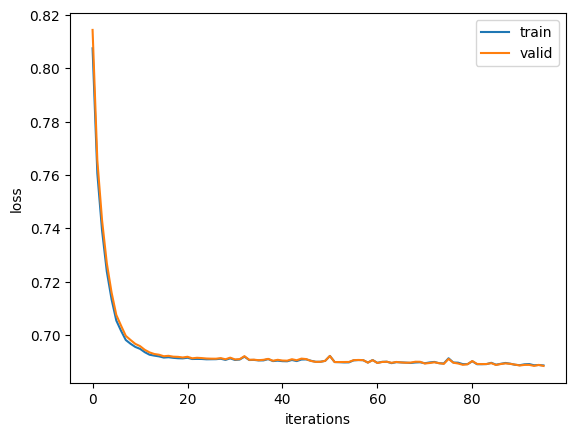

In [10]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

In [11]:
netEv.eval()

with torch.no_grad():
    prediction_test = netEv(X_test).view(-1)

test_acc = torch.isclose(torch.round(prediction_test), y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.551


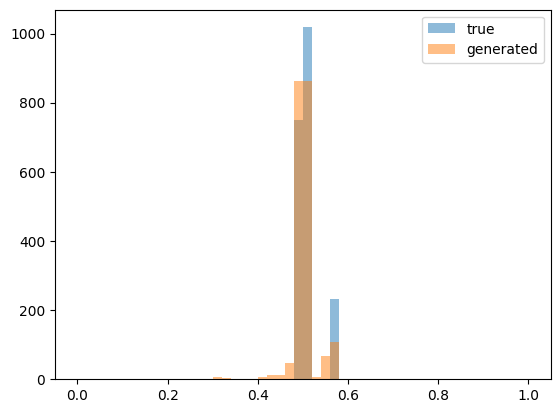

In [12]:
true_indices = y_test.isclose(torch.tensor(1.0))
fake_indices = y_test.isclose(torch.tensor(0.0))

pred_true = prediction_test[true_indices]
pred_fake = prediction_test[fake_indices]

fig, ax = plt.subplots()
ax.hist(pred_true.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="true")
ax.hist(pred_fake.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")
ax.legend()

None